In [318]:
# Open swiss data GeoDataFrame
import geopandas as gpd
import pandas as pd

# Load the data
gdf = gpd.read_file('data/swiss_data_all.csv')

gdf.head()


,idx,geometry,altitude,TypoCH_NUM,Bodentyp,NAHRSTOFF,WASSERDURC,WASSERSPEI
0,35,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",363.5148,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0
1,36,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",358.93480000000005,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0
2,37,"POLYGON ((2485071.58 1111261.72, 2486071.58 11...",387.6868,12.0,-,-9999.0,-9999.0,-9999.0
3,261,"POLYGON ((2486071.58 1109261.72, 2487071.58 11...",415.6684,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0
4,262,"POLYGON ((2486071.58 1110261.72, 2487071.58 11...",368.5936,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0


In [319]:
# Add x and y columns to the GeoDataFrame
from shapely import wkt

gdf['geometry'] = gdf['geometry'].apply(wkt.loads)

In [320]:
# Réccupérer les coordonnées x et y du premier point de chaque polygone
gdf['x'] = None
gdf['y'] = None

for idx, row in gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    gdf.at[idx, 'x'] = x[0]
    gdf.at[idx, 'y'] = y[0]

In [321]:
#Affecte les bons type aux colonnes
gdf['altitude'] = gdf['altitude'].astype(float)
gdf['TypoCH_NUM'] = gdf['TypoCH_NUM'].astype(float)
gdf['NAHRSTOFF'] = gdf['NAHRSTOFF'].astype(float)
gdf['WASSERDURC'] = gdf['WASSERDURC'].astype(float)
gdf['WASSERSPEI'] = gdf['WASSERSPEI'].astype(float)

# Drop the geometry column
gdf = gdf.drop(columns='geometry')

In [322]:
# Étape 1 : Fractionner les chaînes de caractères en listes
gdf['Bodentyp_split'] = gdf['Bodentyp'].str.split('; ')

# Étape 2 : Identifier tous les mots uniques
all_labels = set(label.strip() for sublist in gdf['Bodentyp_split'] for label in sublist)

# Étape 3 : Créer des colonnes dummies
for label in all_labels:
    gdf["Bodentyp_"+label] = gdf['Bodentyp_split'].apply(lambda x: int(label in x))

# Supprimer la colonne temporaire si nécessaire
gdf = gdf.drop(columns=['Bodentyp_split'])
gdf = gdf.drop(columns=['Bodentyp'])
gdf = gdf.drop(columns=['idx'])

In [323]:
# Dummies TypoCH_NUM, NAHRSTOFF, WASSERDURC et WASSERSPEI
gdf = pd.get_dummies(gdf, columns=['TypoCH_NUM', 'NAHRSTOFF', 'WASSERDURC', 'WASSERSPEI'])

In [324]:
#Normalisation des données numériques
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

gdf[['altitude', 'x', 'y']] = scaler.fit_transform(gdf[['altitude', 'x', 'y']])

In [325]:
gdf.head()

,altitude,x,y,"Bodentyp_eutric, dystric Cambisol",Bodentyp_spododystric Cambisol,"Bodentyp_Rendzina (Jura), calcaric Regosol;Podzol","Bodentyp_eutric, gleyic Cambisol","Bodentyp_eutric, gleyic, dystric, calcaric Cambisol","Bodentyp_dystric, eutric Regosol",Bodentyp_Rendzina(Jura),...,WASSERDURC_4.0,WASSERDURC_5.0,WASSERDURC_6.0,WASSERSPEI_-9999.0,WASSERSPEI_1.0,WASSERSPEI_2.0,WASSERSPEI_3.0,WASSERSPEI_4.0,WASSERSPEI_5.0,WASSERSPEI_6.0
0,-1.172443,-2.247749,-1.526134,0,0,0,0,0,0,0,...,False,False,True,False,False,False,False,True,False,False
1,-1.178115,-2.247749,-1.505442,0,0,0,0,0,0,0,...,False,False,True,False,False,False,False,True,False,False
2,-1.142503,-2.247749,-1.484749,0,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,False,False
3,-1.107844,-2.234890,-1.526134,1,1,0,0,0,0,0,...,True,False,False,False,False,False,False,True,False,False
4,-1.166152,-2.234890,-1.505442,1,1,0,0,0,0,0,...,True,False,False,False,False,False,False,True,False,False


In [326]:
#Remove x and y columns to clustering
gdfWithoutCoordinate = gdf.drop(columns=['x', 'y'])


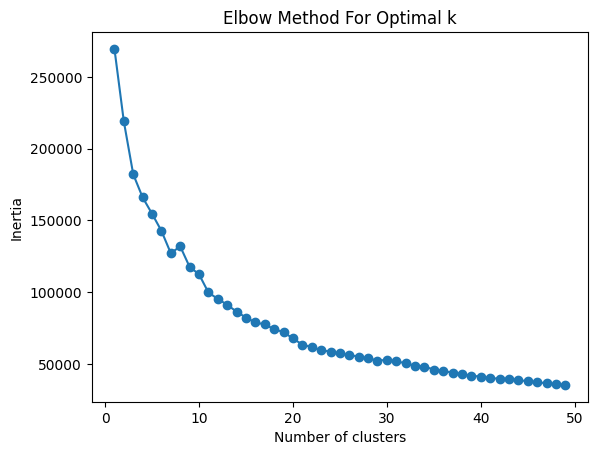

In [327]:
#Get best number of clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate the sum of squared distances for K values in the range 1 to 15
inertia = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(gdfWithoutCoordinate)
    inertia.append(kmeans.inertia_)

# Plot the results
plt.plot(range(1, 50), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [328]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=30)
kmeansError = kmeans.fit_transform(gdfWithoutCoordinate)

gdf['cluster'] = kmeans.labels_
gdf['erreur'] = np.min(kmeansError,1)

(array([1.770e+02, 2.240e+02, 1.650e+02, 1.470e+02, 1.380e+02, 1.220e+02,
        1.200e+02, 9.100e+01, 9.700e+01, 2.180e+02, 1.580e+02, 7.490e+02,
        8.010e+02, 7.580e+02, 5.950e+02, 1.690e+03, 8.070e+02, 6.220e+02,
        7.930e+02, 1.108e+03, 1.236e+03, 7.370e+02, 1.409e+03, 8.980e+02,
        1.442e+03, 7.490e+02, 1.281e+03, 6.340e+02, 7.240e+02, 8.760e+02,
        5.130e+02, 5.920e+02, 1.464e+03, 1.111e+03, 1.360e+03, 1.114e+03,
        1.351e+03, 1.113e+03, 7.540e+02, 8.010e+02, 8.460e+02, 6.400e+02,
        6.170e+02, 5.380e+02, 5.280e+02, 5.130e+02, 6.550e+02, 4.450e+02,
        4.460e+02, 3.950e+02, 3.970e+02, 5.420e+02, 3.770e+02, 3.960e+02,
        4.340e+02, 4.840e+02, 3.520e+02, 2.340e+02, 3.770e+02, 2.910e+02,
        3.490e+02, 2.420e+02, 1.520e+02, 2.140e+02, 2.400e+02, 1.580e+02,
        1.330e+02, 1.790e+02, 1.330e+02, 1.440e+02, 9.300e+01, 9.400e+01,
        7.400e+01, 1.470e+02, 1.950e+02, 1.910e+02, 1.390e+02, 7.700e+01,
        4.300e+01, 4.300e+01, 3.000e+0

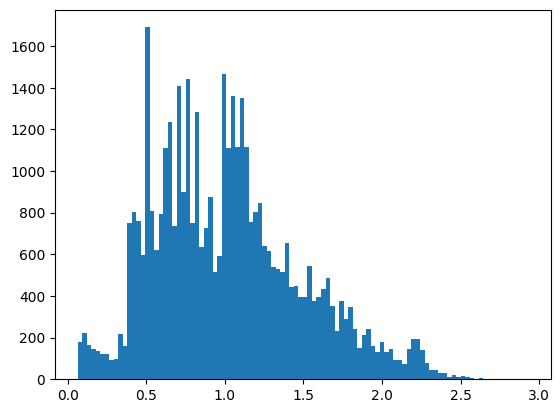

In [329]:
import matplotlib.pyplot as plt

plt.hist(gdf['erreur'], bins=100)

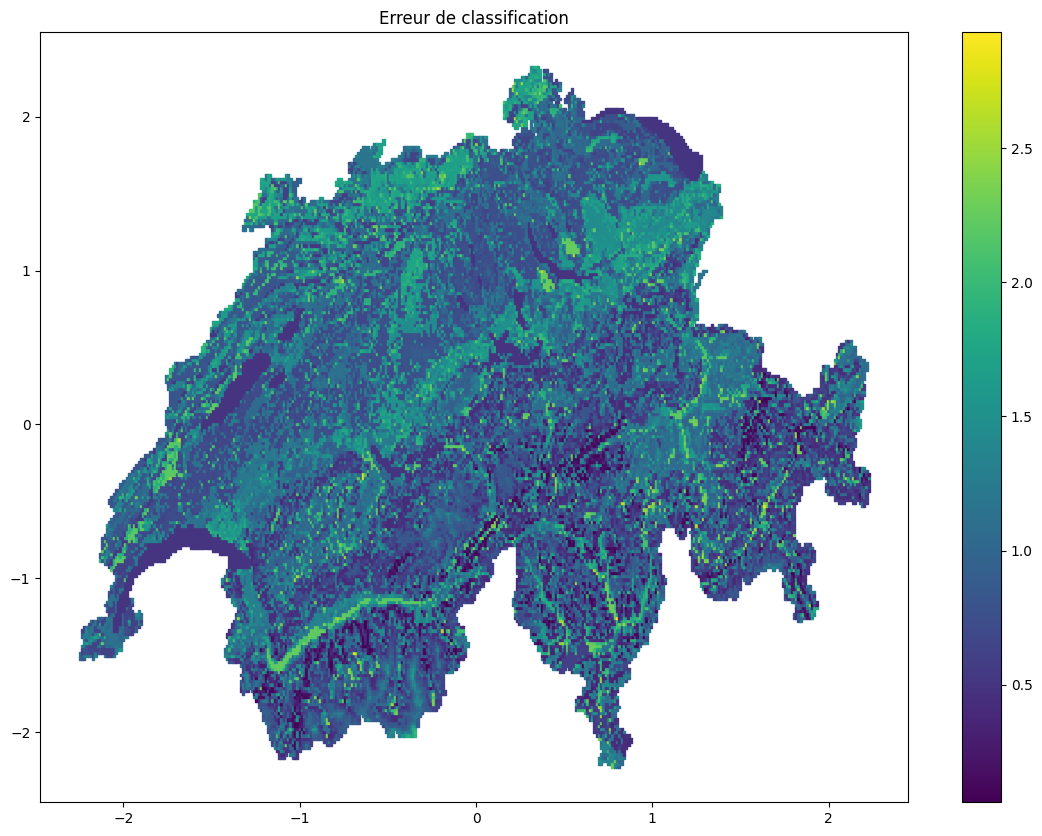

In [330]:
#plot clusters
import matplotlib
import matplotlib.pyplot as plt

squareSize = 2.5

plt.figure(figsize=(14, 10))

plt.scatter(gdf['x'], gdf['y'], c=gdf['erreur'], cmap='viridis', marker='s', s=squareSize)
plt.title('Erreur de classification')
plt.colorbar()
plt.show()


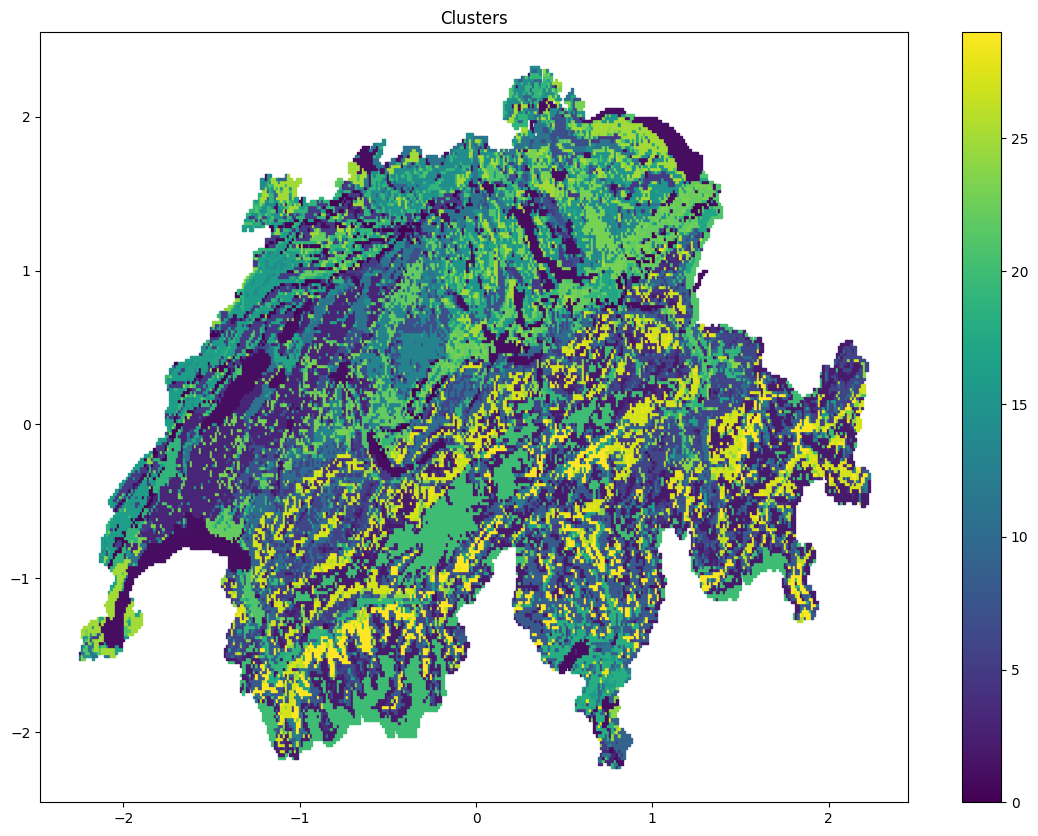

In [331]:
#PLOT DES CLUSTER
plt.figure(figsize=(14, 10))
plt.scatter(gdf['x'], gdf['y'], c=gdf['cluster'], cmap='viridis', marker='s', s=squareSize)
plt.title('Clusters')
plt.colorbar()
plt.show()


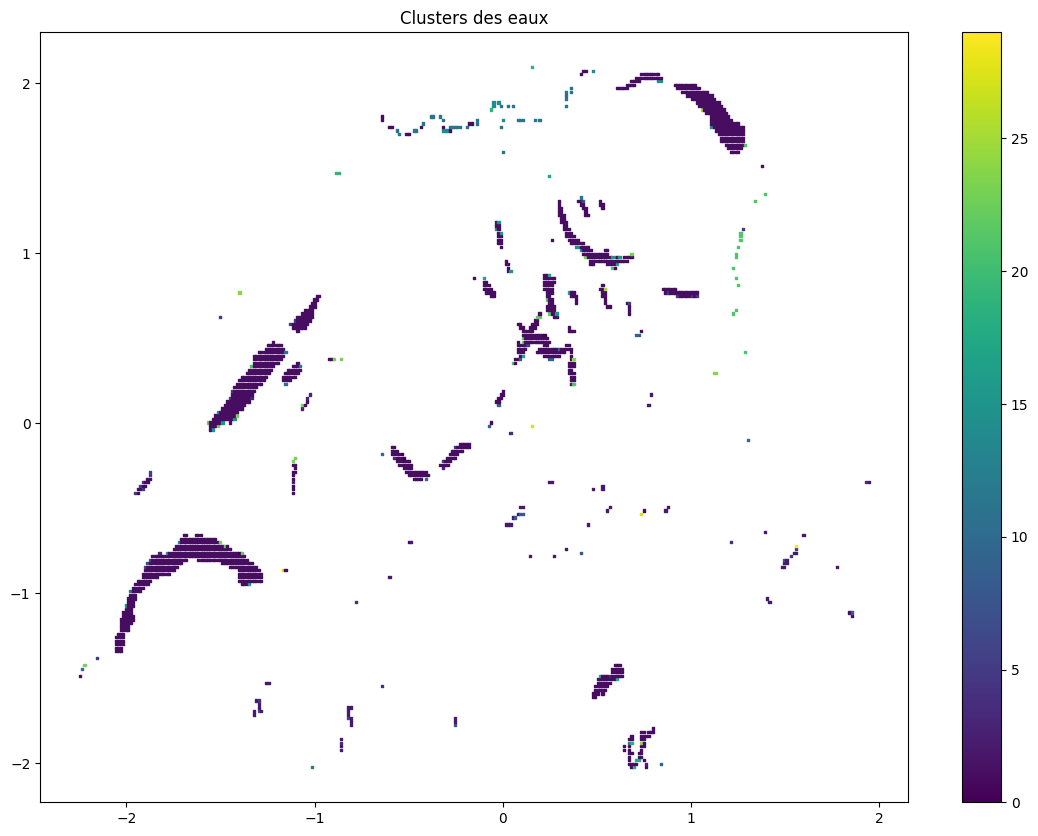

In [332]:
#PLOT DES CLUSTER POUR LES EAUX
gdfLake = gdf[(gdf['TypoCH_NUM_11.0'] == 1) | (gdf['TypoCH_NUM_12.0'] == 1)]

plt.figure(figsize=(14, 10))
plt.scatter(gdfLake['x'], gdfLake['y'], c=gdfLake['cluster'], cmap='viridis', marker='s', s=squareSize)
plt.title('Clusters des eaux')
plt.colorbar()
plt.show()

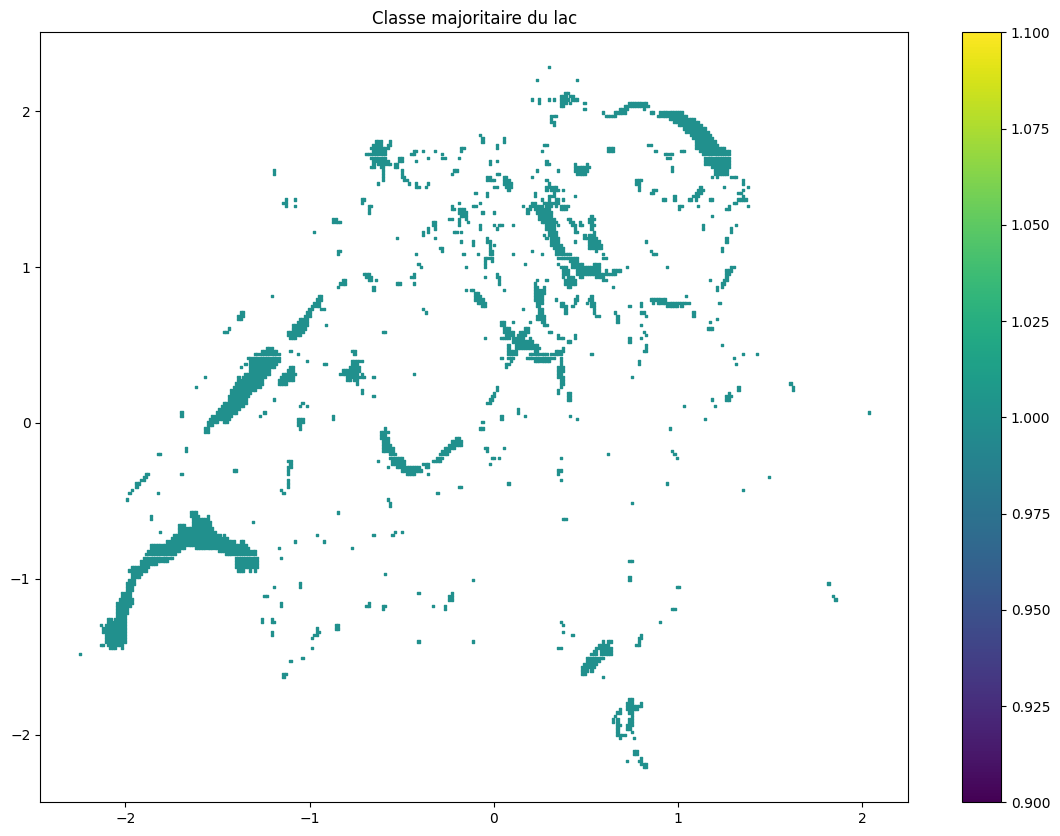

In [333]:
#PLOT DE LA CLASSE CORRESPONDANT MAJORITAIREMENT AU LAC
lakeCluster = gdfLake["cluster"].median()
gdfLakeCluster = gdf[gdf['cluster'] == lakeCluster]

plt.figure(figsize=(14, 10))
plt.scatter(gdfLakeCluster['x'], gdfLakeCluster['y'], c=gdfLakeCluster['cluster'], cmap='viridis', marker='s', s=squareSize)
plt.title('Classe majoritaire du lac')
plt.colorbar()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import pandas as pd
import numpy as np

# Calcul des limites pour une échelle uniforme
x_min, x_max = gdf['x'].min(), gdf['x'].max()
y_min, y_max = gdf['y'].min(), gdf['y'].max()

# Fonction pour tracer les clusters
def plot_cluster(val):
    gdfSigleCluster = gdf[gdf['cluster'] == val]
    plt.figure(figsize=(6, 6))
    plt.scatter(gdfSigleCluster['x'], gdfSigleCluster['y'], 
                c=gdfSigleCluster['cluster'], cmap='viridis', 
                marker='s', s=squareSize)
    plt.title(f'Cluster: {val}')
    plt.xlim(x_min, x_max)  # Appliquer les limites X
    plt.ylim(y_min, y_max)  # Appliquer les limites Y
    plt.show()

# Curseur interactif
interact(plot_cluster, val=IntSlider(min=gdf['cluster'].min(), 
                                     max=gdf['cluster'].max(), 
                                     step=1, 
                                     value=gdf['cluster'].min()))


interactive(children=(IntSlider(value=0, description='val', max=29), Output()), _dom_classes=('widget-interact…

<function __main__.plot_cluster(val)>